In [103]:
# Visualizes results
"""
Job folder has the following output 
x_granular.txt - x training run results
x_results_averaged.txt - 1 number
all_results contains the results dict for 3 * num_training_samples. It is important to average 3s together here 
and NOT average over 15 numbers 
x_granular.txt has 3 averages - so I should take this and average it 

./1
../pred_label_gt10p2
.../x_results_averaged.txt - has all the APs as well (3 * num_training_samples)

.
.

./num_traj
../pred_label_gt10p2
.../x_results_averaged.txt - has all the APs as well (3 * num_training_samples)

So here's what we want to report for gt10p2 - 
collect all these num_traj * 3 * num_training_samples and compute their mean and variance. 


How to average.
For gtxpy, we have num_training_samples * num_traj values. So we take the mean and variance 
of this entire set.

each trajectory has a mean and variance 
so for all trajectories, what is the 

"""


#list dir for all the log files 
import glob
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import numpy as np
import json
import seaborn as sns
import math 
import ast

def getkey_gtfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+4] 
    return int(gt[-2:-1])

def getkey_pfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+2] 
    x = f.find('pred_label')
    if gt == '5p':
        return 5
    return int(gt)


met = ['AP-' + cat for cat in ['chair', 'cushion', 'indoor-plant', 'door', 'table', 'sofa']]
met.insert(0, 'AP')

# class PlotMeanVar:
#     def __init__(self, )

# class AlphaMetrics:
#     def __init__(self):
        
# class BetaMetrics:
#     def __init__(self):
        

def plot(bboxa, bboxd, segma, segmd, xlabel):
    
    def unpack(x):
        res = []
        err = []
        for k, v in x.items():
            res.append(v['mean'])
            err.append(v['std'])
        return res, err
    
    a, b = unpack(bboxa)
    c, d = unpack(bboxd)
    
    # always plot keys on the x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
    ax1.set_title('bbox')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('AP50')
    ax1.errorbar(bboxa.keys(), a, yerr=b, label='active')
    ax1.errorbar(bboxd.keys(), c, yerr=d, label='baseline')
    ax1.legend(loc="lower right")

    a, b = unpack(segma)
    c, d = unpack(segmd)
    
    
    ax2.set_title(f'segm')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('AP50')
    ax2.errorbar(segma.keys(), a, yerr=b, label='active')
    ax2.errorbar(segmd.keys(), c, yerr=d, label='baseline')
    ax2.legend(loc="lower right")

    plt.show()
    
class MeanVar:
    def __init__(self, arr):
        self.arr = arr
        self.mean = np.mean(arr)
        self.var = np.var(arr)

class HyperParams:
    def __init__(self, lr, warmup, iters):
        self.lr = lr
        self.warmup = warmup
        self.iters = iters
        
    def __eq__(self, other): 
        if not isinstance(other, HyperParams):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.lr == other.lr and self.warmup == other.warmup and self.iters == other.iters
    
    def setAP(self, bbox, segm):
        self.bbox = bbox
        self.segm = segm
    
    def get_file_name_pref(self):
        return f'{self.lr} {self.warmup} {self.maxiters} *.txt'
    
    def __repr__(self):
        return f'lr {self.lr} warmup {self.warmup} iters {self.iters}'
    
def process_hpm(x):
    x = x.strip()
    x = x.split()
#     print(x)
    assert len(x) == 6
    return HyperParams(lr=float(x[1]), warmup=int(x[3]), iters=int(x[5]))

def process_met(x):
    x = x.strip()
    x = ast.literal_eval(x)
#     x = x.split()
#     print(type(x), x)
    return x['bbox']['AP'], x['segm']['AP']
    
def shorten(outdir):
    if "straightline" in outdir: # baseline
        return "active " + "/".join(outdir.split('/')[-3:])
    return "baseline " + "/".join(outdir.split('/')[-2:])

def get_test_score(outdir, bh):
    tf = os.path.join(outdir, '750', str(bh.lr), str(bh.warmup), 'test_results.txt')
    if not os.path.isfile(tf):
        print(f'{tf} does not exist!!')
        
    # read the line with bhpm
    res = None
    bbox = []
    segm = []
    with open(tf) as f:
        lines = f.readlines()
        for i in range(0, len(lines), 4):
#             print(f'i {lines[i]}')
#             print(f'i+1 {lines[i+1]}')
            hpm = process_hpm(lines[i])
            if hpm == bh:
#                 res found
                for j in range(3):
                    bb, ss = process_met(lines[i+1+j])
                    bbox.append(bb)
                    segm.append(ss)
                break
#     print(f'testAP {res}')
    return bbox, segm

def get_best_test_ap(outdir):
#     print(f'read_results {outdir}')
    bh = get_best_hyperparam_file(outdir)
#     print(f'best hyperparams for {shorten(outdir)}, {bh if bh else None}')
    
    if bh:
        bbox, segm = get_test_score(outdir, bh)
#         print(f'bbox mean AP {np.mean(bbox)}, segm mean AP {np.mean(segm)}')
        return MeanVar(bbox), MeanVar(segm)
    
    return None, None

def get_best_hyperparam_file(outdir):
    val_fs = glob.glob(outdir + '/**/validation_results.txt', recursive=True) # get all the validation files
#     print(f'globbed {len(val_fs)} validation files')
    best_val = 1000000
    bhpm = None
    bb = 0
    for x in val_fs:
        with open(x) as f:
            lines = f.readlines()
            for i in range(0, len(lines), 3):
                hpm = process_hpm(lines[i])
                val_loss = float(lines[i+1].split()[-1])
                if val_loss < best_val:
                    best_val = val_loss
                    bhpm = hpm
    return bhpm

def alphametrics(arrs, vis=False):
    # just take the overall average
    r = []
    for x in arrs:
        r.append(x.arr)
    r = [item for sublist in r for item in sublist]
#     print(f'{len(r)} samples')
    if vis:
        sns.kdeplot(r)
        plt.show()
    return np.mean(r), np.var(r), len(r)

def is_pred_label_gtp_valid(pred_f, gt):
#     return os.path.isfile(os.path.join(pred_f, 'validation_results.txt'))
    return True
#     with open(os.path.join(pred_f, 'train_img_id.json'), 'r') as f:
#         dat = json.load(f)
# #     print(f"{pred_f, len(set(dat['img_id'])), gt}")
#     return len(set(dat['img_id'])) >= gt-2

def get_meanvar_for_alltraj_gtxpy(job_root, gt, p, num_traj, pref, metric, num_samples):
    bbox = []
    segm = []
    for traj in range(num_traj):
        pth = os.path.join(job_root, 'code/output_droid', str(traj), pref, f'pred_label_gt{gt}p{p}')
        if os.path.isdir(pth):
            # check if this is a valid folder 
            for x in range(num_samples):
                sp = os.path.join(pth, str(x))
#                 print(f'looking at {sp} ...')
                # get the best hyper-param for this and the corresponding test AP 
                bb, se = get_best_test_ap(sp)
                if bb and se:
                    bbox.append(bb)
                    segm.append(se)

    if metric == 'alpha':
        return alphametrics(bbox), alphametrics(segm) 
    else:
        return betametrics(bbox), betametrics(segm)

def get_all(job_root, num_traj, gts, ps, metric, num_samples, pref=''):
    bbox = defaultdict(lambda: defaultdict(int))
    segm = defaultdict(lambda: defaultdict(int))
    if len(ps) == 1:
        for gt in gts:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gt, ps[0], num_traj, pref, metric, num_samples)
            bbox[gt]['mean'], bbox[gt]['std'] = bb[0], math.sqrt(bb[1])
            segm[gt]['mean'], segm[gt]['std'] = se[0], math.sqrt(se[1])
            
    if len(gts) == 1:
        for p in ps:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gts[0], p, num_traj, pref, metric, num_samples)
            print(f'gt {gts[0]}, p {p}, bbox {bb[0]}, segm {se[0]}, bbox samples {bb[2]}, segm samples {se[2]}')
            bbox[p]['mean'], bbox[p]['std'] = bb[0], math.sqrt(bb[1])
            segm[p]['mean'], segm[p]['std'] = se[0], math.sqrt(se[1])
            
    return bbox, segm


def compare(job_root_act, job_root_baseline, num_traj, gts, ps, act_pref, metric, xlabel, num_samples):
    bm_act, sm_act = get_all(job_root_act, num_traj, gts, ps, metric, num_samples, act_pref)
    bm_def, sm_def = get_all(job_root_baseline, num_traj, gts, ps, metric, num_samples)
    plot(bm_act, bm_def, sm_act, sm_def, xlabel)


alpha - overall mean and var
gt 5, p 0, bbox 15.117411832386253, segm 15.304597985740477, bbox samples 24, segm samples 24
gt 5, p 2, bbox 16.22899175183381, segm 15.138233198099044, bbox samples 24, segm samples 24
gt 5, p 4, bbox 12.593753188214487, segm 11.027735817715447, bbox samples 24, segm samples 24
gt 5, p 6, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 5, p 8, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 5, p 0, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 5, p 2, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 5, p 4, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 5, p 6, bbox nan, segm nan, bbox samples 0, segm samples 0
gt 5, p 8, bbox nan, segm nan, bbox samples 0, segm samples 0


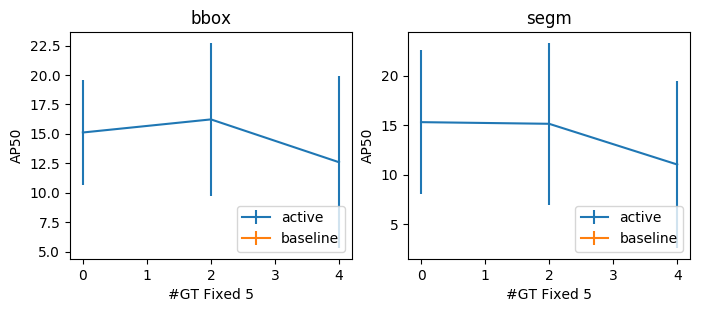

In [104]:
print('alpha - overall mean and var')

compare(
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-11-2021/09:20:11', 
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/08-11-2021/00:38:20', 
    5, [5], [0, 2,4,6,8], act_pref='default', metric='alpha', xlabel=f'#GT Fixed {gtfix}', num_samples=3
)
